# Visualizing Quality Attribute Coupling with Cross Correlation

# Getting started

Run the Quartermaster simulation to produce the time series data in `out\models\` and aggregate data in `out\models\scenario`

In [49]:
import numpy as np
import pandas as pd
from IPython.display import display


ALoad = pd.read_csv("../out/models/A-100-Naive-VaryLoad.csv")
BLoad = pd.read_csv("../out/models/B-100-LoadLeveling-VaryLoad.csv")
CLoad = pd.read_csv("../out/models/C-100-LoadShedding-VaryLoad.csv")
DLoad = pd.read_csv("../out/models/D-100-MultilevelLoadShedding-VaryLoad.csv")
Load = { "A":ALoad, "B":BLoad, "C":CLoad, "D":DLoad }

ALatency = pd.read_csv("../out/models/A-100-Naive-VaryLatency.csv")
ELatency = pd.read_csv("../out/models/E-100-RequestCaching-VaryLatency.csv")
FLatency = pd.read_csv("../out/models/F-100-AsyncCacheLoading-VaryLatency.csv")
GLatency = pd.read_csv("../out/models/G-100-PerRequestTimeout-VaryLatency.csv")
Latency = { "A":ALatency, "E":ELatency, "F":FLatency, "G":GLatency }

AAvailability = pd.read_csv("../out/models/A-100-Naive-VaryAvailability.csv")
HAvailability = pd.read_csv("../out/models/H-100-Retries-VaryAvailability.csv")
FAvailability = pd.read_csv("../out/models/F-100-AsyncCacheLoading-VaryAvailability.csv")
IAvailability = pd.read_csv("../out/models/I-100-AsyncRetries-VaryAvailability.csv")
JAvailability = pd.read_csv("../out/models/J-100-InfiniteRetries-VaryAvailability.csv")
Availability = { "A":AAvailability, "H":HAvailability, "F":FAvailability, "I":IAvailability, "J":JAvailability }

ACapacity = pd.read_csv("../out/models/A-100-Naive-VaryCapacity.csv")
KCapacity = pd.read_csv("../out/models/K-100-CooperativePoolSizing-VaryCapacity.csv")
LCapacity = pd.read_csv("../out/models/L-100-InferredPoolSizing-VaryCapacity.csv")
Capacity = { "A":ACapacity, "K":KCapacity, "L":LCapacity }


You are currently viewing what we call our Notebook Editor. It is an interactive document based on Jupyter Notebooks that supports the intermixing of code, outputs and markdown documentation. 

This cell is a markdown cell. To edit the text in this cell, simply double click on the cell to change it into edit mode.

The next cell below is a code cell. You can switch a cell between code and markdown by clicking on the code ![code icon](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/codeIcon.PNG) /markdown ![markdown icon](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/markdownIcon.PNG) icons or using the keyboard shortcut `M` and `Y` respectively.

Load
	loadOnZ
		A (0.0, 0.9999993603740083)
		B (79.0, 0.8463964035860198)
		C (76.0, 0.9375699397813813)
		D (76.0, 0.9347437002898494)
	meanLatencyFromY
		A (-38.0, 0.8930129183820436)
		B (-70.0, 0.9398199467750697)
		C (-73.0, 0.9074551545591336)
		D (-72.0, 0.8552613402240967)
Latency
	meanLatencyFromY
		A (0.0, 0.9216642256430881)
		E (6.0, 0.9444526083699165)
		F (80.0, nan)
		G (-48.0, 0.1592461727155612)
	meanAvailabilityFromZ
		A (-40.0, 0.9529859960772059)
		E (44.0, 0.9476931688251962)
		F (-63.0, 0.27850001607127794)
		G (40.0, 0.9472489120251003)
Availability
	meanAvailabilityFromZ
		A (0.0, 0.9999999999999999)
		H (0.0, 0.922395283076448)
		F (10.0, 0.8049730650857739)
		I (-66.0, 0.3308725655108052)
		J (-70.0, 0.623670151878327)
	loadOnZ
		A (80.0, nan)
		H (40.0, 0.9893372903074891)
		F (80.0, nan)
		I (-40.0, 0.9465950686931353)
		J (-40.0, 0.9458776615506816)
Capacity
	workerThreadPoolSizeInY
		A (80.0, nan)
		K (0.0, 0.9999132088999584)
		L (-71.0, 0.89794315919822

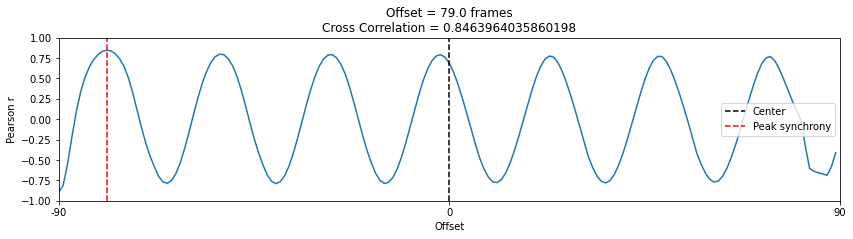

In [60]:
""" Some assistance from this article
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
"""

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


import matplotlib.pyplot as plot


# meanLatencyFromY  meanLatencyFromZ
def timeseriescorrelation(df, d1name, d2name):
    d1 = df[d1name]
    d2 = df[d2name]
    period = 80
    rs = [crosscorr(d1,d2, lag) for lag in range(-period,period)]
    maxCrossCorr = np.amax(rs)
    maxCrossCorrIndex = np.argmax(rs)
    offset = np.floor(len(rs)/2)-maxCrossCorrIndex
    # f,ax=plot.subplots(figsize=(14,3))
    # ax.plot(rs)
    # ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    # ax.axvline(maxCrossCorrIndex,color='r',linestyle='--',label='Peak synchrony')
    # ax.set(title=f'Offset = {offset} frames\nCross Correlation = {maxCrossCorr}',ylim=[-1,1],xlim=[0,100], xlabel='Offset',ylabel='Pearson r')
    # ax.set_xticks([0, 80, 160])
    # ax.set_xticklabels([-80, 0, 80]);
    # plot.legend()
    return offset, maxCrossCorr


print("Load")
print("\tloadOnZ")
for key, series in Load.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "loadFromX", "loadFromY"))
print("\tmeanLatencyFromY")
for key, series in Load.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "loadFromX", "meanLatencyFromY"))
    #print(f"\t\t{key}", timeseriescorrelation(series, "meanLatencyFromY", "meanLatencyFromZ"))

print("Latency")
print("\tmeanLatencyFromY")
for key, series in Latency.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "meanLatencyFromZ", "meanLatencyFromY"))
print("\tmeanAvailabilityFromZ")
for key, series in Latency.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "meanLatencyFromZ", "meanAvailabilityFromY"))
    #print(f"\t\t{key}", timeseriescorrelation(series, "meanAvailabilityFromY", "meanAvailabilityFromZ"))

print("Availability")
print("\tmeanAvailabilityFromZ")
for key, series in Availability.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "meanAvailabilityFromZ", "meanAvailabilityFromY"))
    #print(f"\t\t{key}", timeseriescorrelation(series, "meanAvailabilityFromY", "meanAvailabilityFromZ"))
print("\tloadOnZ")
for key, series in Availability.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "meanAvailabilityFromZ", "loadFromY"))
    #print(f"\t\t{key}", timeseriescorrelation(series, "loadFromX", "loadFromY"))

print("Capacity")
print("\tworkerThreadPoolSizeInY")
for key, series in Capacity.items():
    print(f"\t\t{key}", timeseriescorrelation(series, "zCapacity", "poolSize"))


df = BLoad
#driven
d1 = df["loadFromX"] 
d2 = df["loadFromY"]
period = 90
rs = [crosscorr(d1,d2, lag) for lag in range(-period,period)]
maxCrossCorr = np.amax(rs)
maxCrossCorrIndex = np.argmax(rs)
offset = np.floor(len(rs)/2)-maxCrossCorrIndex
f,ax=plot.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(maxCrossCorrIndex,color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nCross Correlation = {maxCrossCorr}',ylim=[-1,1],xlim=[0,100], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, period, period*2])
ax.set_xticklabels([-period, 0, period])
plot.legend()


## Unfortunate Problems

### E Latency > A Latency
- A is 0 delay, cross correlation = 0.921664
- E is 6 delay, cross correlation = 0.944452

Is this bad or good?

# Features

**Variable explorer**

To view all your active variables and their current values in the notebook, click on the variable explorer icon ![variable explorer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/variableExplorerIcon.PNG) in the top toolbar.

![Variable Explorer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/variableexplorer.png)

**Data Viewer**

To view your data frame in a more visual "Excel" like format, open the variable explorer and to the left of any dataframe object, you will see the data viewer icon ![data viewer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/dataViewerIcon.PNG) which you can click to open the data viewer.

![Data Viewer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/dataviewer.gif)

**Convert to Python File**

To export your notebook to a Python file (.py), click on the `Convert to Python script` icon ![Export icon](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/exportIcon.PNG) in the top toolbar 

![Export](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/savetopythonfile.png)

**Plot Viewer**

If you have a graph (such as matplotlib) in your output, you'll notice if you hover over the graph, the `Plot Viewer` icon ![Plot Viewer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/plotViewerIcon.PNG) will appear in the top left. Click the icon to open up the graph in the Plotviewer which allows you to zoom on your plots and export it in formats such as png and jpeg.

![Plot Viewer](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/plotviewer.gif)

**Switching Kernels**

The notebook editor will detect all kernels in your system by default. To change your notebook kernel, click on the kernel status in the top toolbar at the far right. For example, your kernel status may say "Python 3: Idle". This will open up the kernel selector where you can choose your desired kernel.

![Switching Kernels](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/kernelchange.gif)

**Remote Jupyter Server**

To connect to a remote Jupyter server, open the command prompt and search for the command `Specify remote or local Jupyter server for connections`. Then select `Existing` and enter the remote Jupyter server URL. Afterwards, you'll be prompted to reload the window and the Notebook will be opened connected to the remote Jupyter server.

![Remote](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/remoteserver.gif)

# More Resources

- [Data science tutorial for Visual Studio Code](https://code.visualstudio.com/docs/python/data-science-tutorial)
- [Jupyter Notebooks in Visual Studio Code documentation](https://code.visualstudio.com/docs/python/jupyter-support)